In [19]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [20]:
otto_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [32]:
test_df.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
0,1,0,0,0,0,0,0,0,0,0,...,0,0,11,1,20,0,0,0,0,0
1,2,2,2,14,16,0,0,0,0,0,...,0,0,0,0,0,4,0,0,2,0
2,3,0,1,12,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1
3,4,0,0,0,1,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,1,2,0,...,0,0,0,0,0,0,0,9,0,0


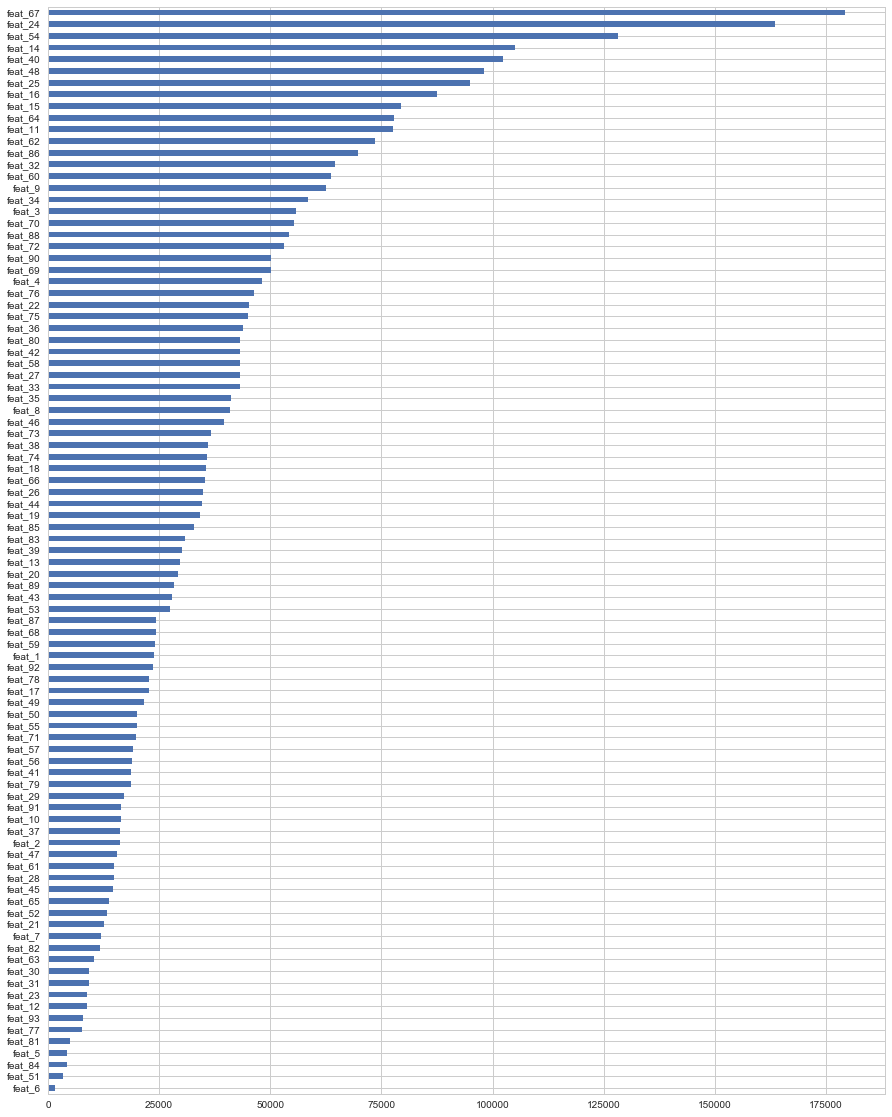

In [30]:


# product features

# Plot summation for every product feature
sum_otto = otto_df.sum()
sum_otto.drop(['target', 'id']).sort_values().plot(kind='barh', figsize=(15,20))


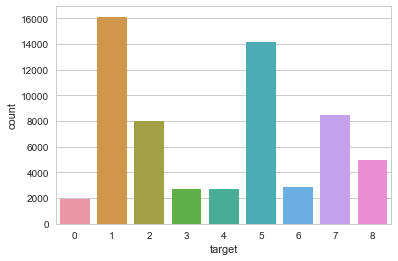

In [22]:
# target

# map each class to numerical value from 0 to 8(i.e. 9 classes)
range_of_classes = range(1, 10)
map_values_dic   = {}

for n in range_of_classes:
    map_values_dic['Class_{}'.format(n)] = n - 1

otto_df['target'] = otto_df['target'].map(map_values_dic)

# Plot
sns.countplot(x='target', data=otto_df)

In [35]:
# define training and testing sets

X_train = otto_df.drop(["id", "target"],axis=1)
Y_train = otto_df["target"].copy()

X_test  = test_df.drop("id",axis=1).copy()

In [36]:
# Xgboost 
# Normal way
params = {"objective": "multi:softprob", "num_class": 9}

T_train_xgb = xgb.DMatrix(X_train, Y_train)
X_test_xgb  = xgb.DMatrix(X_test)

gbm = xgb.train(params, T_train_xgb, 20)
Y_pred = gbm.predict(X_test_xgb)


In [40]:

# Using Validation Set
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.01)

params = {"objective": "multi:softprob", "num_class": 38}

T_train_xgb = xgb.DMatrix(X_train, Y_train)
T_valid_xgb = xgb.DMatrix(X_valid, Y_valid)
X_test_xgb  = xgb.DMatrix(X_valid)
watchlist = [(T_valid_xgb, 'eval'), (T_train_xgb, 'train')]

gbm = xgb.train(params, T_train_xgb, 20, evals=watchlist, early_stopping_rounds=10)
Y_pred = gbm.predict(X_test_xgb)



[0]	eval-merror:0.304778	train-merror:0.272873
Multiple eval metrics have been passed: 'train-merror' will be used for early stopping.

Will train until train-merror hasn't improved in 10 rounds.
[1]	eval-merror:0.286656	train-merror:0.257766
[2]	eval-merror:0.273476	train-merror:0.247139
[3]	eval-merror:0.265239	train-merror:0.239478
[4]	eval-merror:0.258649	train-merror:0.233098
[5]	eval-merror:0.260297	train-merror:0.226586
[6]	eval-merror:0.255354	train-merror:0.222206
[7]	eval-merror:0.250412	train-merror:0.217026
[8]	eval-merror:0.248764	train-merror:0.213128
[9]	eval-merror:0.250412	train-merror:0.21018
[10]	eval-merror:0.252059	train-merror:0.206849
[11]	eval-merror:0.250412	train-merror:0.204101
[12]	eval-merror:0.250412	train-merror:0.201619
[13]	eval-merror:0.242175	train-merror:0.198837
[14]	eval-merror:0.237232	train-merror:0.196789
[15]	eval-merror:0.240527	train-merror:0.194024
[16]	eval-merror:0.235585	train-merror:0.191875
[17]	eval-merror:0.23229	train-merror:0.190126

In [44]:
Y_train = np.array(Y_train)

In [50]:
Y_train.shape

(60039,)

In [48]:
np.sum((Y_train - Y_pred)**2)/len(Y_train)

ValueError: operands could not be broadcast together with shapes (60039,) (607,38) 

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_train, Y_pred))

ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'multiclass'}

In [26]:
# Create submission

submission = pd.DataFrame({ "id": test_df["id"]})

i = 0

# Create column name based on target values(see sample_submission.csv)
for num in range_of_classes:
    col_name = str("Class_{}".format(num))
    submission[col_name] = Y_pred[:,i]
    i = i + 1
    
submission.to_csv('otto.csv', index=False)

In [27]:


submission.head()



,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.004308,0.228767,0.210220,0.517464,0.002072,0.010231,0.016153,0.005820,0.004964
1,2,0.067904,0.144746,0.041965,0.030591,0.009855,0.502248,0.022844,0.156243,0.023604
2,3,0.001296,0.000907,0.001118,0.000859,0.000361,0.984360,0.001060,0.008373,0.001665
3,4,0.008403,0.539400,0.319334,0.069979,0.004268,0.012172,0.011461,0.012373,0.022610
4,5,0.055436,0.008913,0.008640,0.005544,0.008100,0.021228,0.010915,0.226965,0.654260


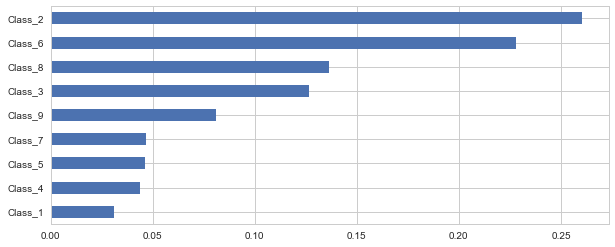

In [29]:
# target
# It shows the arrangement of the average of predictions for every target(class) in submission

submission.drop(["id"], axis=1).mean().sort_values().plot(kind='barh', figsize=(10,4))